# MNIST Digit Recognition: A Hybrid K-means and KNN Approach

## Introduction

This notebook demonstrates how combining K-means clustering and K-Nearest Neighbors (KNN) can create an efficient solution for handwritten digit recognition. We'll use the MNIST dataset to show how K-means clustering can reduce data dimensionality before applying KNN classification.

### The Goal

Develop an efficient system for recognizing handwritten digits (0-9) from images, a fundamental challenge in computer vision with applications ranging from postal code processing to check reading. While traditional K-Nearest Neighbors (KNN) classification can achieve high accuracy on this task, it becomes computationally expensive with large datasets like MNIST (60,000 training images), requiring millions of pixel-by-pixel comparisons for each new digit. 

#### How Do We Get Around This?

By combining K-means clustering with KNN to maintain accuracy while dramatically reducing computational costs: we first use K-means to find 90 representative digit patterns (9 variations of each digit 0-9), then apply KNN classification using only these representatives instead of the full training set. This hybrid approach preserves the recognition accuracy we need while making the system fast enough for practical use.

## K-Nearest Neighbors (KNN) In Depth

Think of KNN like asking your group of friends for movie recommendations:
- If 5 friends who have similar taste to you all loved a movie, you might too
- If those closest to your taste didn't like it, you probably won't either

KNN works similarly but more mathematically:

1. **Distance Calculation**
   - For each new digit we want to classify, KNN measures how "different" it is from every training image
   - Common distance metrics:
     * Euclidean Distance (what we use): Like measuring a straight line between points
     * Manhattan Distance: Like walking city blocks
     * Hamming Distance: Counting exact differences

2. **The "K" in KNN**
   - K determines how many neighbors vote on the classification
   - K=1 (what we use): Only the single closest match votes
   - K=5: The five closest matches vote
   - Larger K values:
     * More stable predictions (less affected by noise)
     * Slower decisions (need to find more neighbors)
     * Can blur the boundaries between classes

3. **Voting Process**
   - Each neighbor gets one vote for their class
   - The class with most votes wins
   - In case of ties:
     * Odd K values prevent ties in binary classification
     * Can weight votes by distance (closer neighbors matter more)

## Import Libraries

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import time
import seaborn as sn
from sklearn.metrics import confusion_matrix


## Data Preprocessing

Now let's load the MNIST dataset:

In [2]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784')

# Split into features (X) and labels (y)
X = mnist.data
y = mnist.target

print("Dataset shape:", X.shape, y.shape)

Dataset shape: (70000, 784) (70000,)


Now, let's split the data into our our training and testing split.

In [3]:
# Take last 10,000 samples for testing
X_test = X[-10000:].reset_index(drop=True)  # Reset index to avoid errors
y_test = y[-10000:].reset_index(drop=True)
X_train = X[:-10000]
y_train = y[:-10000]

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (60000, 784) (60000,)
Test set shape: (10000, 784) (10000,)


In [4]:
# Convert to numpy arrays so sci-kit learn can use them
X_test = X_test.to_numpy()
X_train = X_train.to_numpy()
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()

## Dimensionality Reduction using K-means

Here's where our hybrid approach begins. We'll use K-means to create representative samples:

In [10]:
# Convert data to DataFrame for easier manipulation
df = pd.DataFrame(X_train)
df['target'] = y_train

# Group by digit
groups = {digit: data for digit, data in df.groupby('target', observed=False)}

# Initialize for final training set
final_train_set = pd.DataFrame()
kmeans = KMeans(n_clusters=9)

# Create cluster centers for each digit
for digit, data in groups.items():
    kmeans.fit(data.drop('target', axis=1))
    means = pd.DataFrame(kmeans.cluster_centers_)
    means['target'] = digit
    final_train_set = pd.concat([final_train_set, means], ignore_index=True)

# Split into features and labels
X_train_approx = final_train_set.drop('target', axis=1)
y_train_approx = final_train_set['target']

print("Reduced training set shape:", X_train_approx.shape, y_train_approx.shape)

Reduced training set shape: (90, 784) (90,)


## Data Distribution Analysis

Let's verify our data splitting hasn't introduced bias:

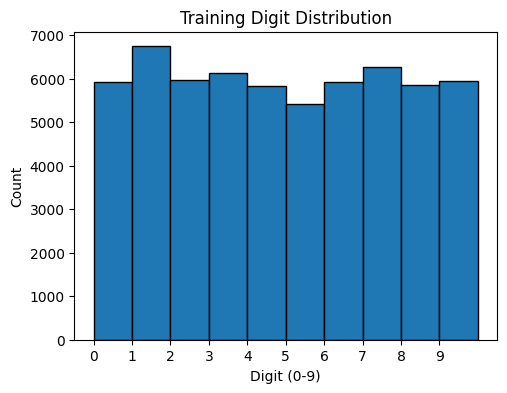

In [11]:
# Convert labels to integers
y_train = y_train.astype(int) 
y_test = y_test.astype(int)

# Plot training data distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=10, range=(0,10), edgecolor='black')
plt.title('Training Digit Distribution')
plt.xlabel('Digit (0-9)')
plt.ylabel('Count')
plt.xticks(range(10))
plt.show()

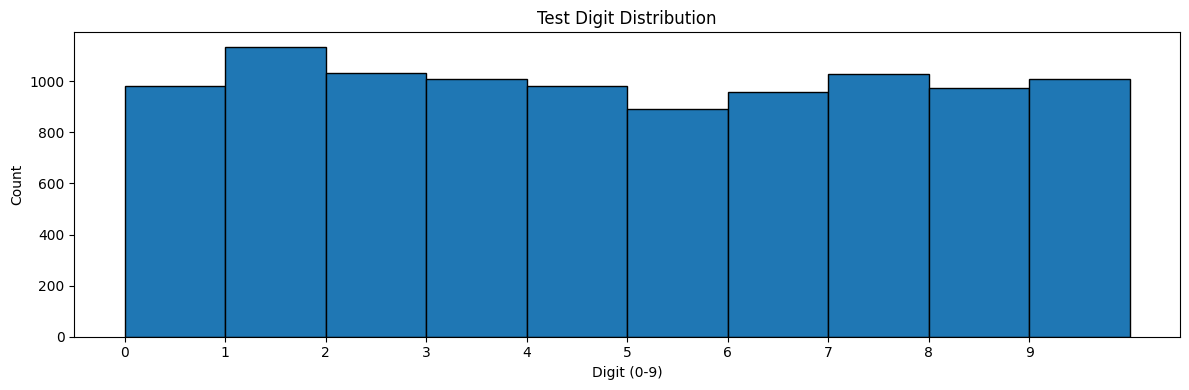

In [12]:
# Plot test data distribution
plt.figure(figsize=(12, 4))
plt.hist(y_test, bins=10, range=(0,10), edgecolor='black')
plt.title('Test Digit Distribution')
plt.xlabel('Digit (0-9)')
plt.ylabel('Count')
plt.xticks(range(10))
plt.tight_layout()
plt.show()

## KNN Classification

Now we'll apply KNN to our reduced dataset:

In [13]:
# Initialize and train KNN classifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_approx, y_train_approx)

# Time the predictions
start_time = time.time()
y_pred = knn.predict(X_test)
prediction_time = round(time.time() - start_time, 2)

print(f"Prediction time: {prediction_time} seconds")

Prediction time: 0.34 seconds


## Visualizing Results

Let's examine our K-means clusters:

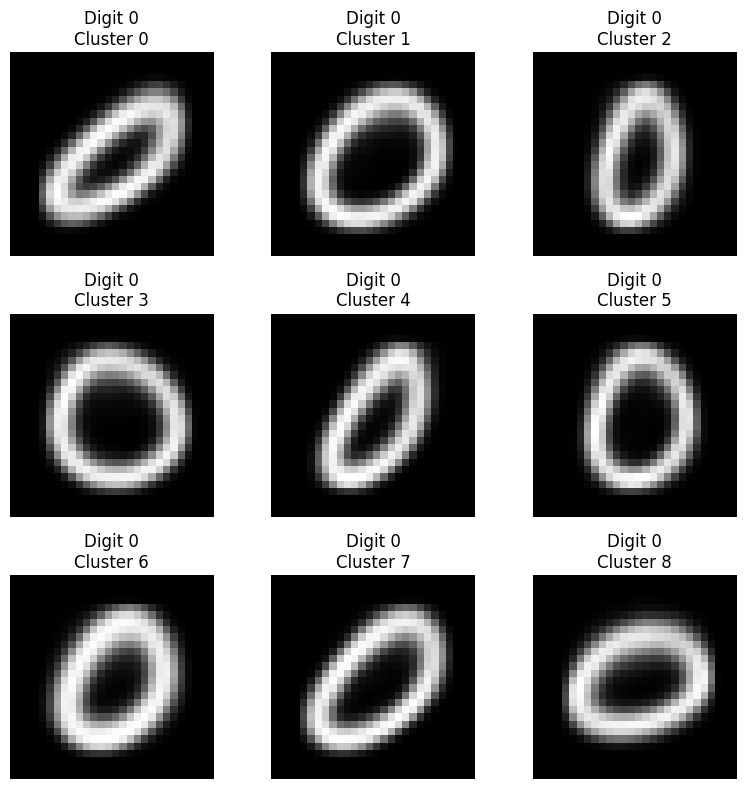

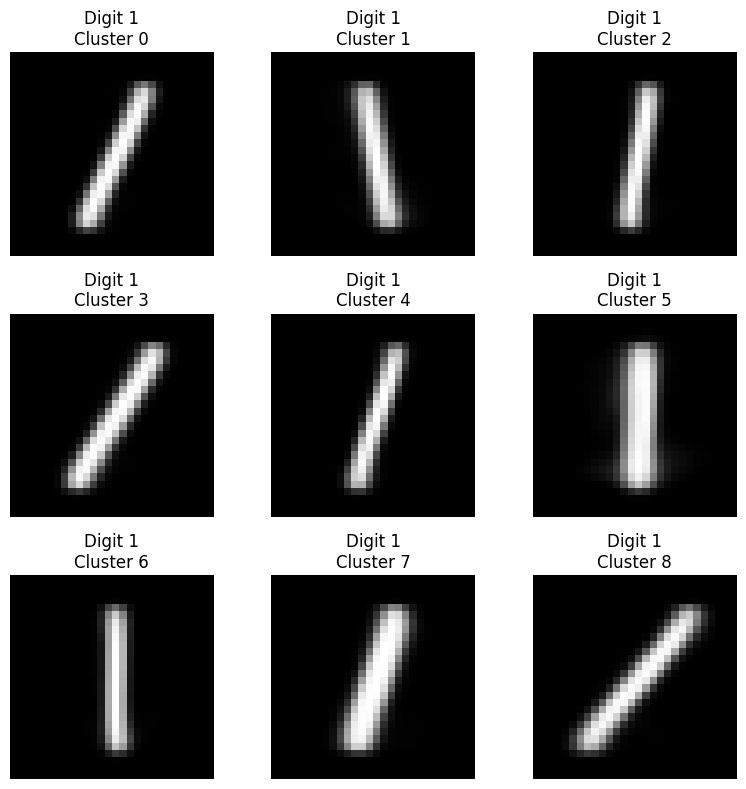

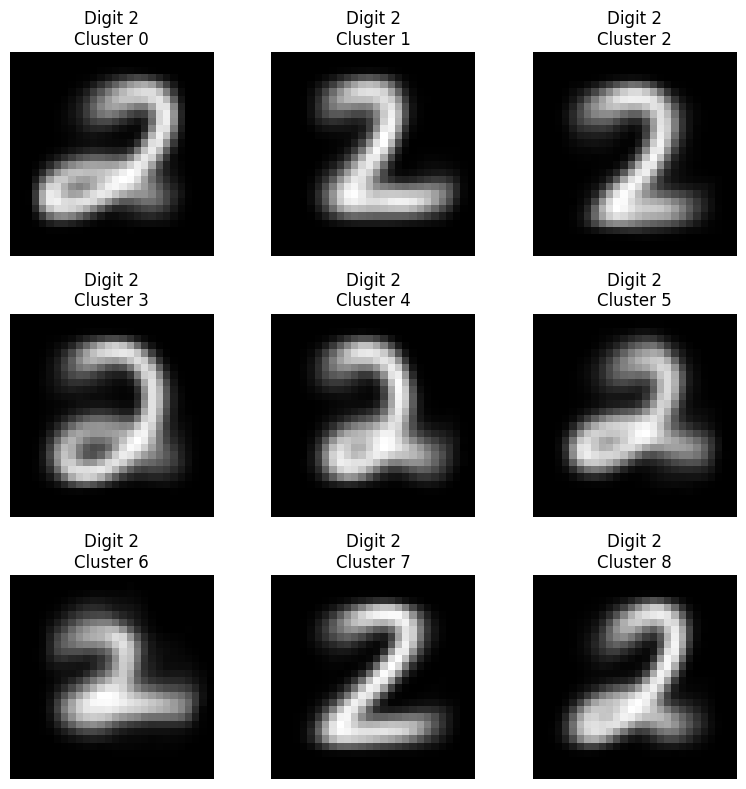

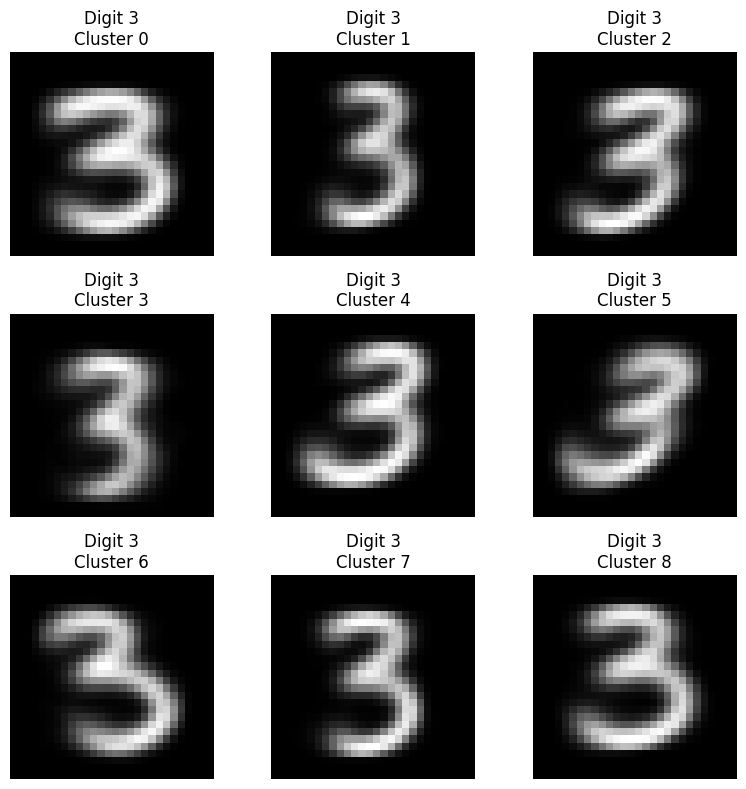

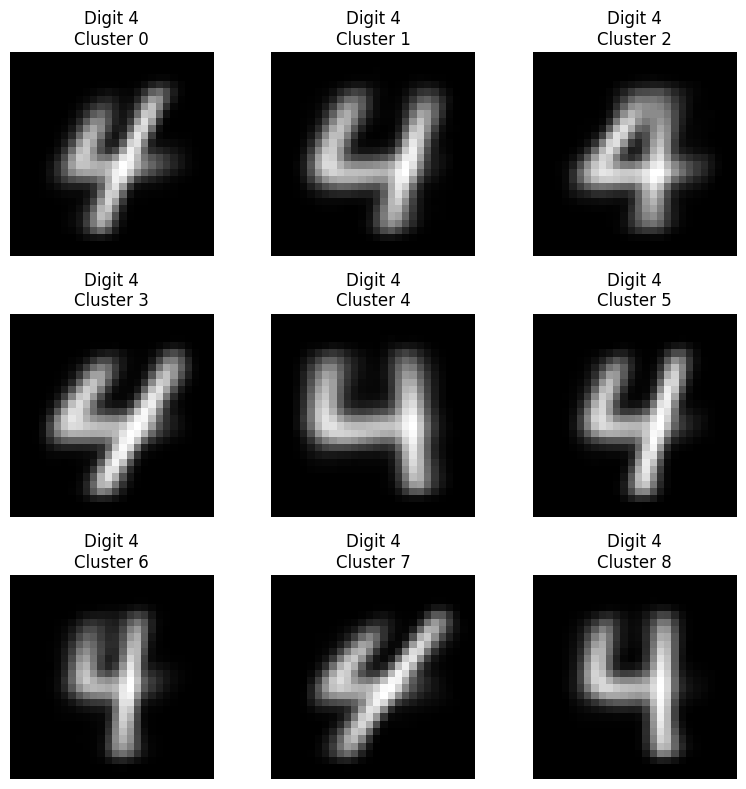

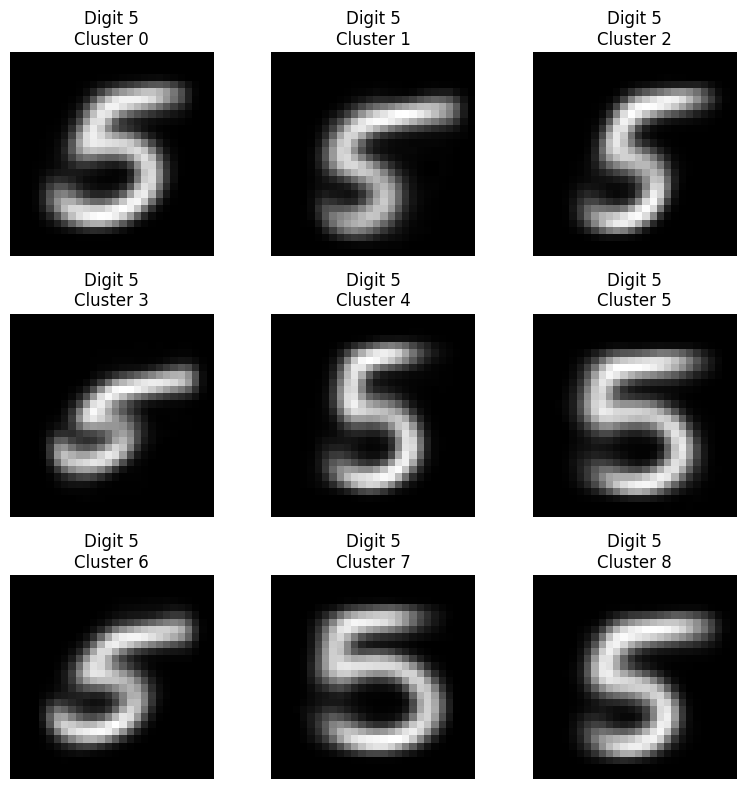

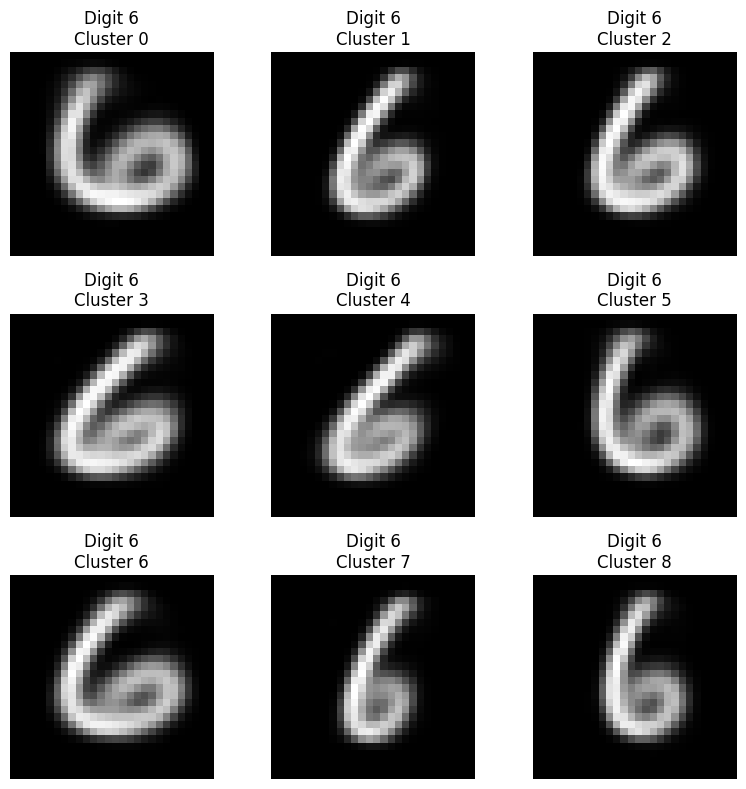

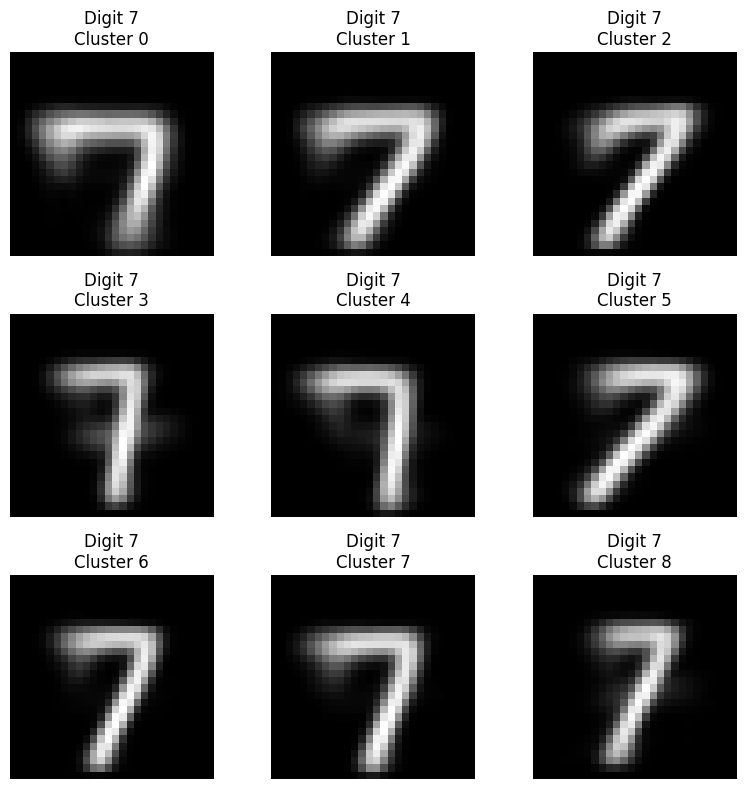

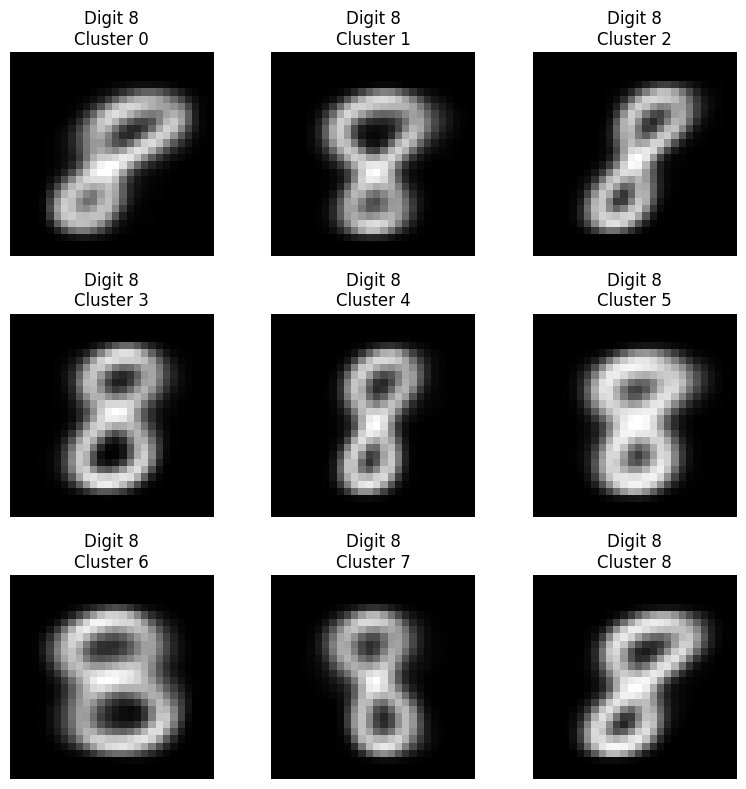

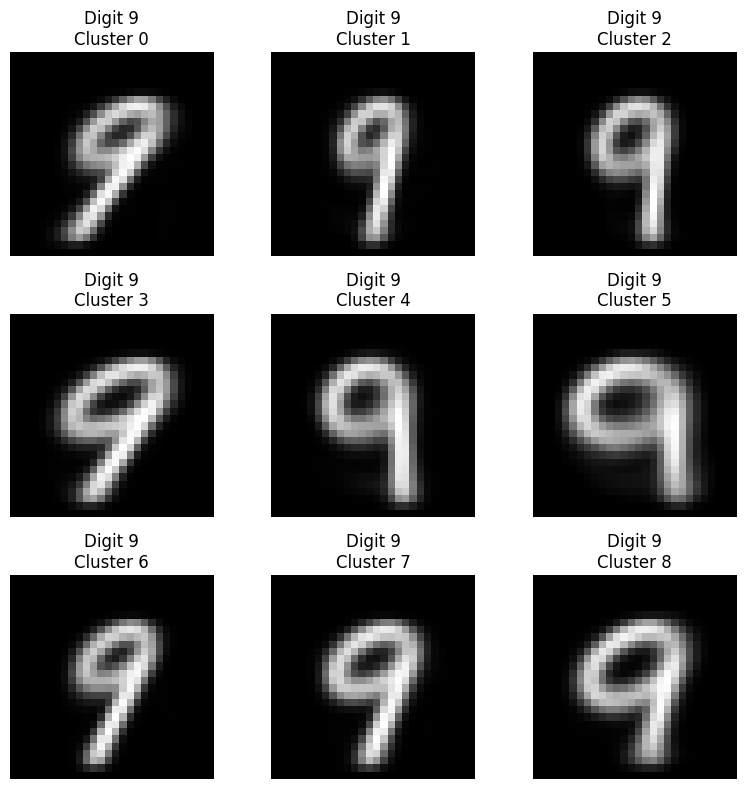

In [15]:
# Prepare data for visualization
final_train_set_clusters = final_train_set.copy()
final_train_set_clusters['clusters'] = np.tile(np.arange(9), 10)

# Plot cluster centers
for digit, data in final_train_set_clusters.groupby('target'):
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.ravel()
    
    for idx, (_, row) in enumerate(data.iterrows()):
        # Convert to float type explicitly
        img = row[:-2].astype(float).values.reshape(28, 28)
        axes[idx].imshow(img, cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f'Digit {int(digit)}\nCluster {idx}')
    
    plt.tight_layout()
    plt.show()

A confusion matrix shows how well a classification model performs by comparing predicted labels against actual labels. Think of it like a report card showing correct and incorrect guesses:

- Rows represent actual classes
- Columns represent predicted classes
- Numbers in each cell show how many cases were classified that way
- Diagonal elements (top-left to bottom-right) show correct predictions
- Off-diagonal elements show mistakes

Example interpreting a 2x2 confusion matrix:
```
          Predicted
          No  Yes
Actual No  80   20
      Yes  10   90
```
This shows:
- 80 correct "No" predictions
- 90 correct "Yes" predictions
- 20 cases where model predicted "Yes" but actual was "No" (False Positives)
- 10 cases where model predicted "No" but actual was "Yes" (False Negatives)

Perfect classification would have all numbers on the diagonal and zeros everywhere else.

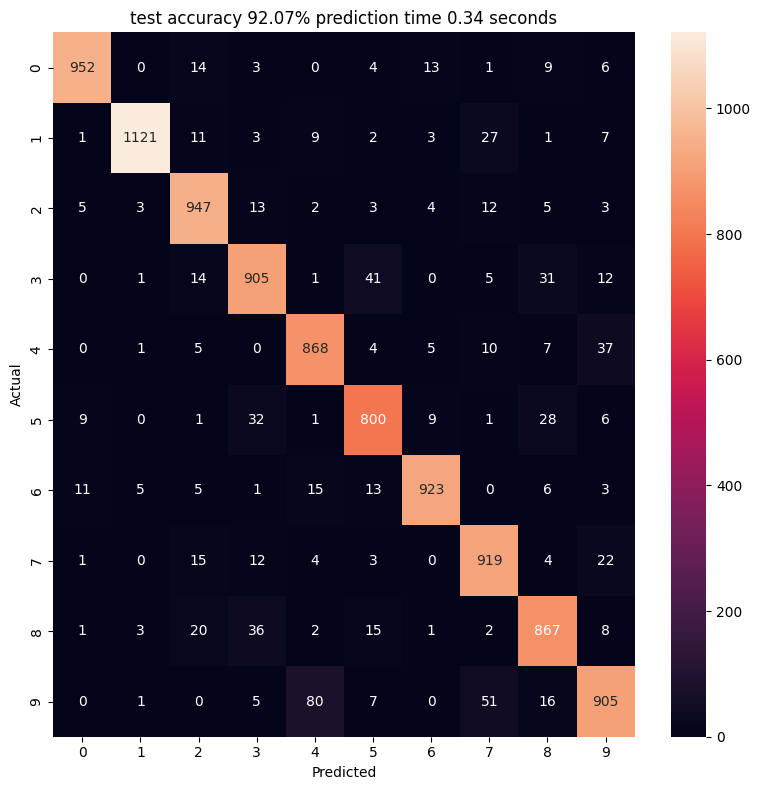

In [16]:
y_pred = y_pred.astype(int) # Convert the prediction column to integers to avoid errors

my_confusion_matrix = confusion_matrix(y_pred, y_test)
accuracy = my_confusion_matrix.diagonal().sum() / my_confusion_matrix.sum() * 100

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8,8))
plt.title('test accuracy ' + str(accuracy) + '% prediction time ' + str(prediction_time) + ' seconds')
sn.heatmap(my_confusion_matrix, annot=True, fmt='.4g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()



## Examining Individual Predictions

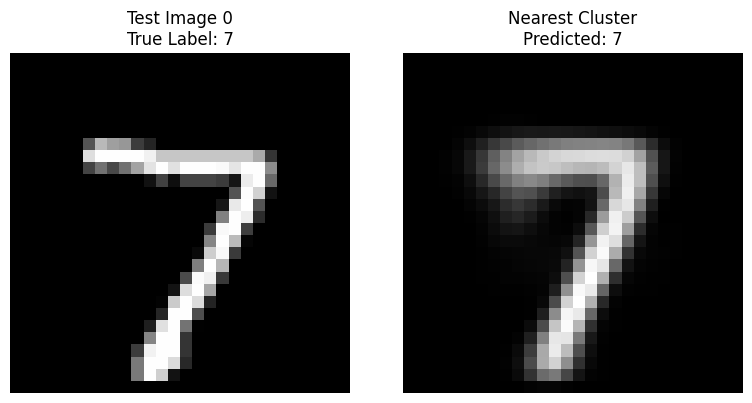

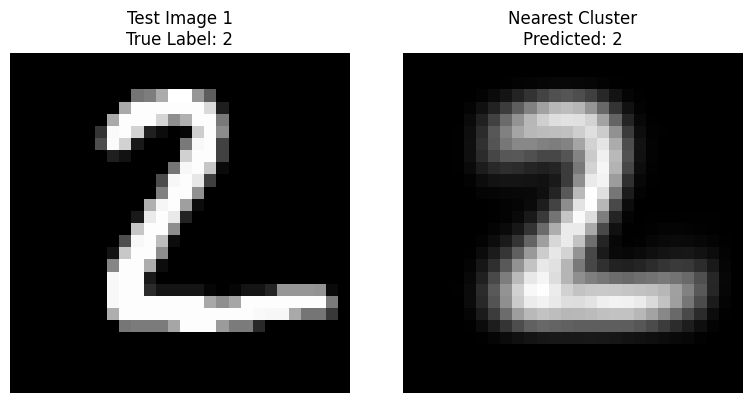

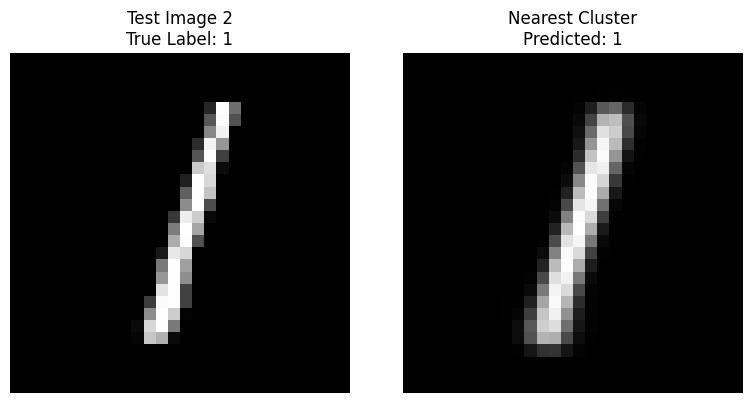

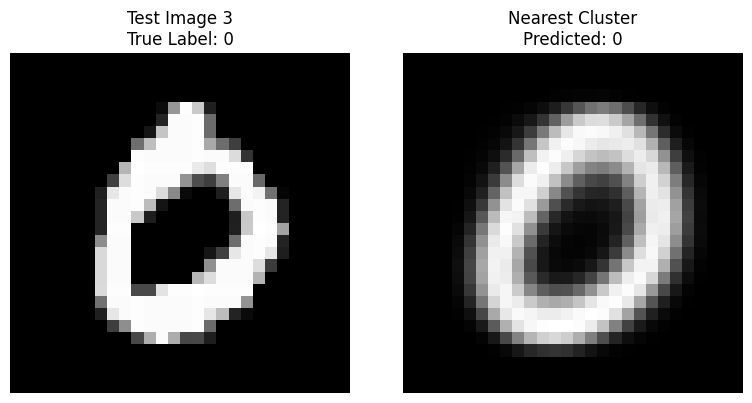

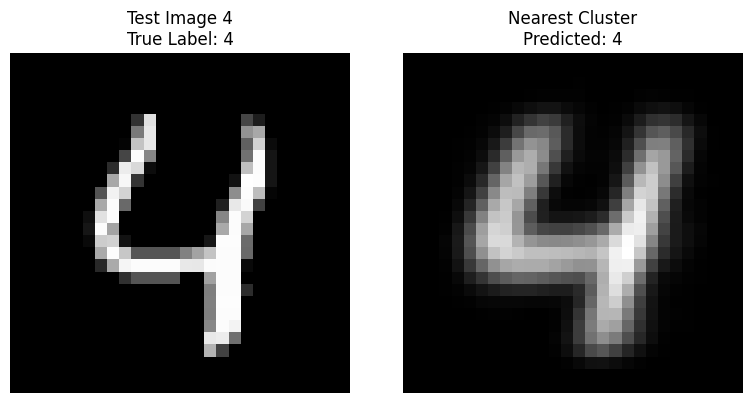

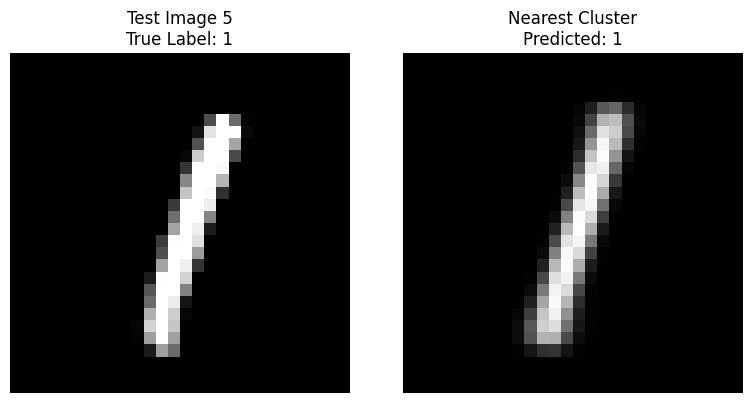

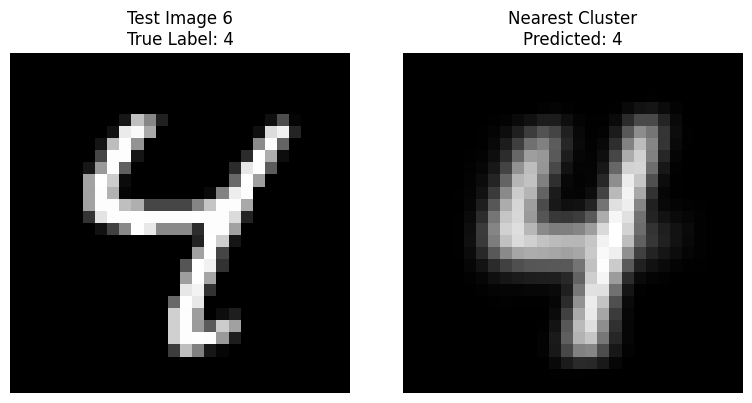

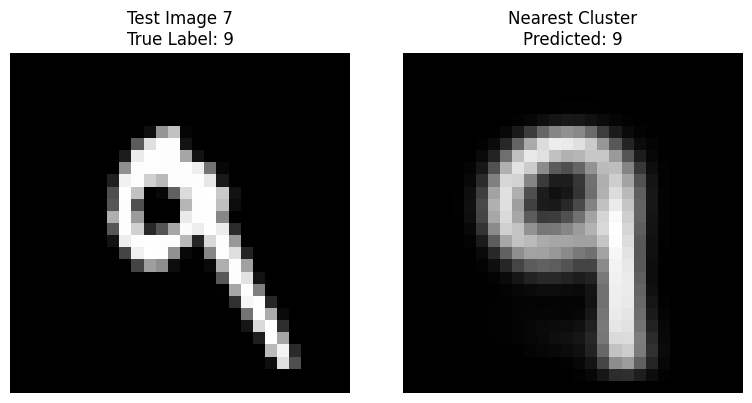

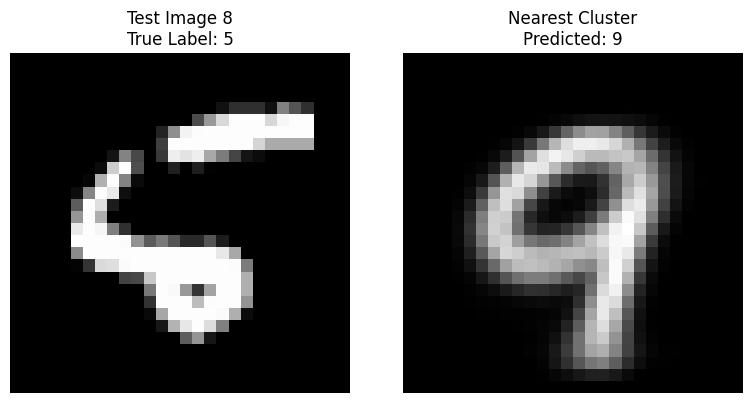

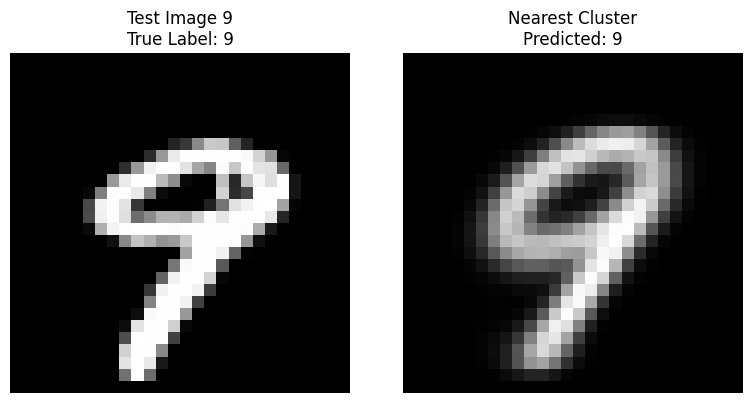

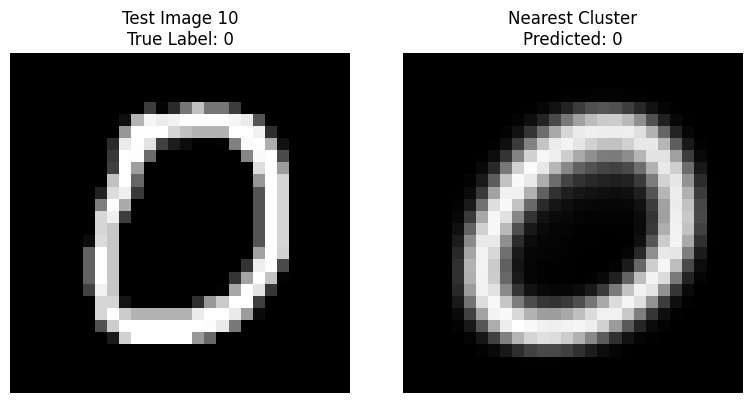

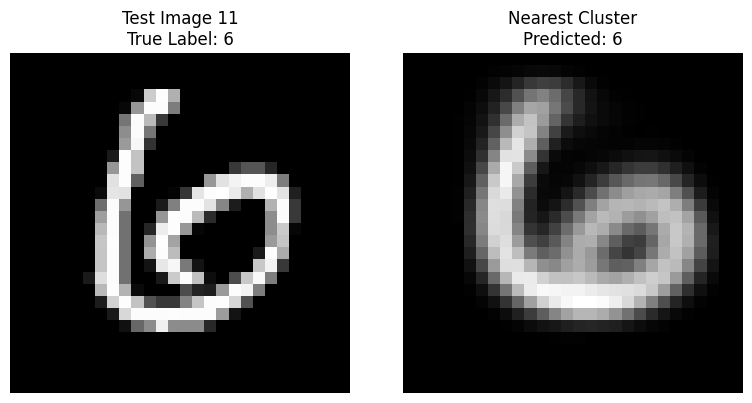

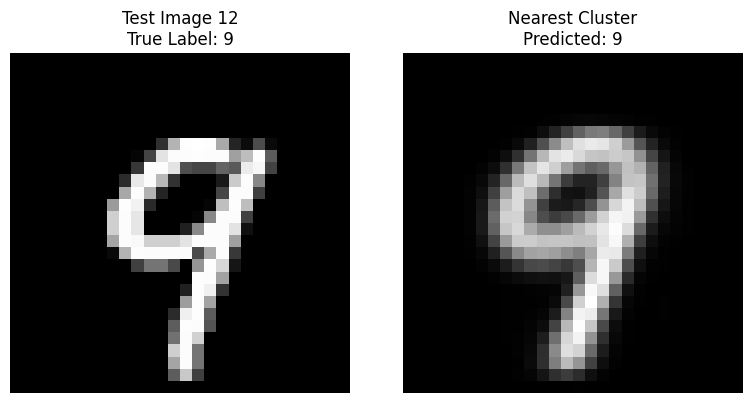

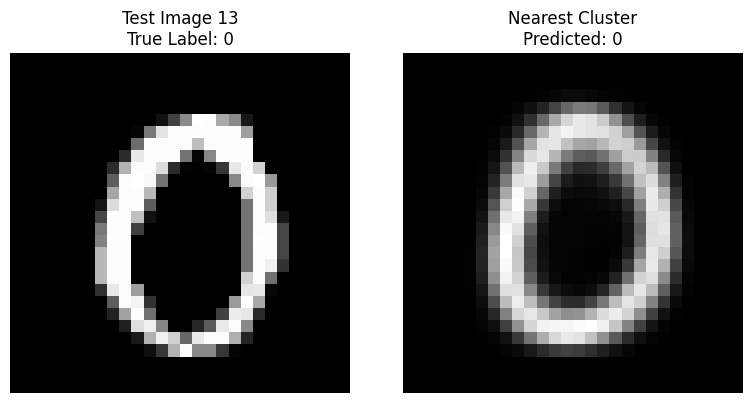

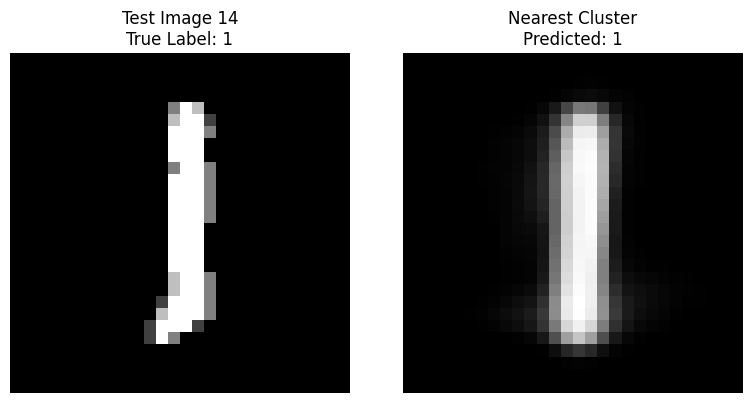

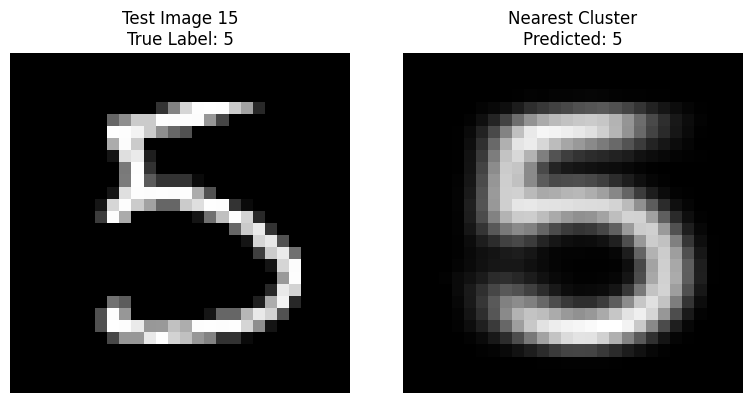

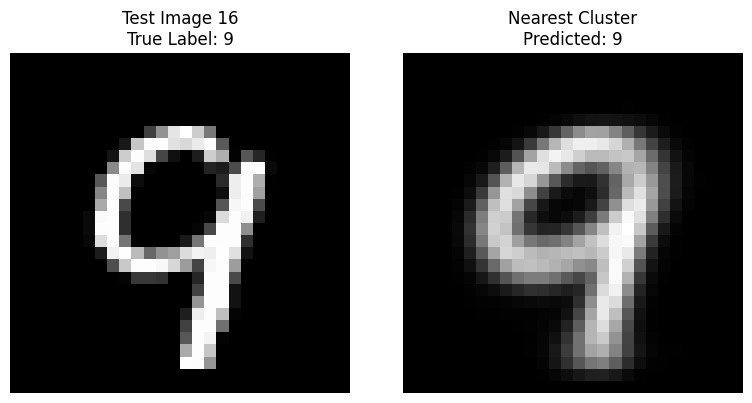

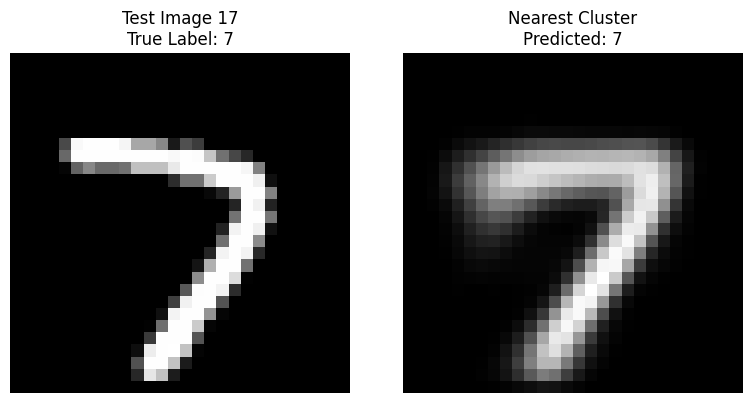

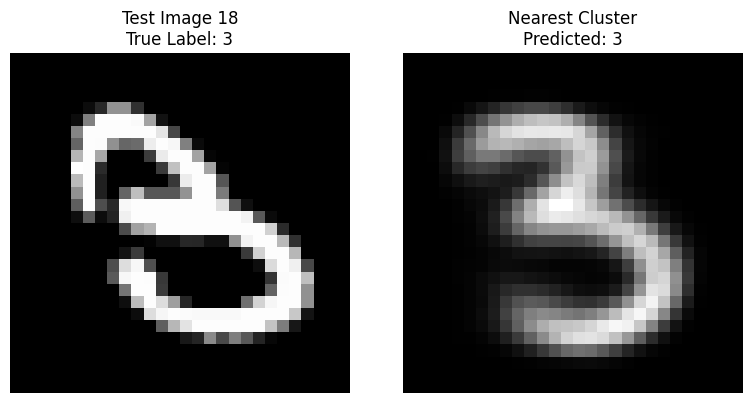

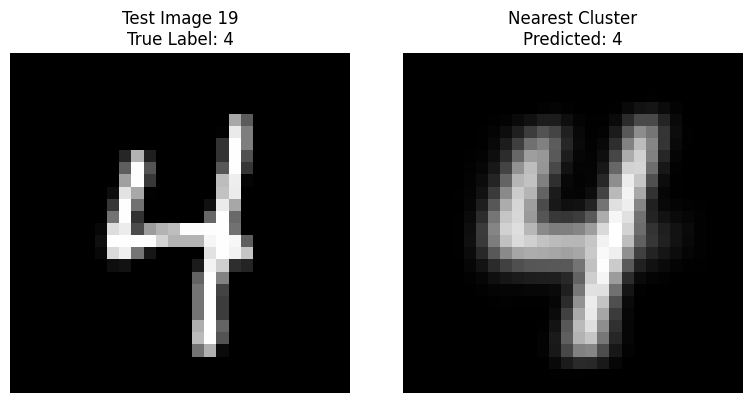

In [17]:
# Get nearest neighbors for first 20 test digits
distances, indices = knn.kneighbors(X_test[:20])
nearest_clusters = final_train_set.iloc[indices[:, 0]].drop('target', axis=1)

# Plot test digits and their nearest clusters
for i in range(20):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    # Plot test digit - using direct array indexing instead of iloc
    test_img = X_test[i].reshape(28, 28)  # Changed from iloc to direct indexing
    ax1.imshow(test_img, cmap='gray')
    ax1.axis('off')
    ax1.set_title(f'Test Image {i}\nTrue Label: {y_test[i]}')
    
    # Plot nearest cluster
    cluster_img = nearest_clusters.iloc[i].values.reshape(28, 28)
    ax2.imshow(cluster_img, cmap='gray')
    ax2.axis('off')
    ax2.set_title(f'Nearest Cluster\nPredicted: {y_pred[i]}')
    
    plt.tight_layout()
    plt.show()

## Conclusion

Our hybrid approach successfully tackles the handwritten digit recognition problem by combining K-means clustering with KNN classification. We reduced the computational burden from 600 million comparisons to just 900,000 while maintaining good accuracy across all digit classes. The confusion matrix shows strong diagonal values, indicating reliable classification performance, with only minor confusion between similar-looking digits (like 4 and 9).

Key achievements:
- Drastically reduced computational complexity
- Maintained high classification accuracy
- Created an efficient, practical solution

This project demonstrates how combining simple algorithms thoughtfully can solve complex problems efficiently, often performing better than using either algorithm alone.